In [236]:
from HTML import config as Config
from HTML.dataset import *
from HTML.config import ratio, nominal, ordinal, meaningless
from HTML.preprocessing import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [237]:
df_train = pd.read_csv(Config.train_path)
df_train.head()

,ID,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,Resort Hotel,0,342,2015,July,27,1,0,0,...,No Deposit,NaN,NaN,0,Transient,-6.305161,0,0,Check-Out,2015-07-01
1,1,City Hotel,0,257,2015,July,27,1,0,2,...,No Deposit,6.0,NaN,0,Transient,75.052227,0,0,Check-Out,2015-07-03
2,2,City Hotel,0,257,2015,July,27,1,0,2,...,No Deposit,6.0,NaN,0,Transient,74.546401,0,0,Check-Out,2015-07-03
3,3,City Hotel,0,257,2015,July,27,1,0,2,...,No Deposit,6.0,NaN,0,Transient,76.376288,0,0,Check-Out,2015-07-03
4,4,City Hotel,0,257,2015,July,27,1,0,2,...,No Deposit,6.0,NaN,0,Transient,49.411647,0,0,Check-Out,2015-07-03


In [238]:
df_train.shape

(91531, 33)

In [239]:
df_train = preprocessing(df_train)

In [240]:
df_train.shape

(91527, 33)

In [241]:
fact = pd.factorize(df_train['reservation_status'])
y_train_res = fact[0]
y_train_adr = df_train[df_train['adr'] < 5000]['adr'].to_numpy()

In [242]:
from sklearn.preprocessing import OneHotEncoder

In [243]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [280]:
categories = df_train[sorted(list(set(nominal+ordinal) - {'adr', 'reservation_status', 'reservation_status_date', 'is_canceled', 'ID', 'index'}))].astype(str).to_numpy()
cat = enc.fit_transform(categories)

In [281]:
cat.shape

(91527, 941)

In [282]:
num = df_train[sorted(list(set(df_train.columns) - set(nominal+ordinal) - {'adr', 'reservation_status', 'reservation_status_date', 'is_canceled', 'ID', 'index'}))].to_numpy()

In [283]:
num.shape

(91527, 13)

In [284]:
tmp = np.concatenate((cat, num), axis=1)
x_train_res = tmp.copy()
x_train_adr = tmp[df_train['adr'] < 5000,:].copy()

In [285]:
# dummies = pd.get_dummies(
#         data=df_train[set(df_train.columns) - {'reservation_status', 'reservation_status_date', 'is_canceled'}],
#         columns=set(nominal+ordinal) - {'reservation_status', 'reservation_status_date', 'is_canceled'},
#         drop_first=True,
#         dummy_na=True)
# dummies = dummies[sorted(set(dummies.columns) - {'index', 'ID'} - set(meaningless))]
# x_train_res = dummies[sorted(list(set(dummies.columns) - {'adr'}))].to_numpy()
# x_train_adr = dummies[dummies['adr'] < 5000][sorted(list(set(dummies.columns) - {'adr'}))].to_numpy()

In [286]:
print('adr:', x_train_adr.shape, y_train_adr.shape)
print('res:', x_train_res.shape, y_train_res.shape)

adr: (91526, 954) (91526,)
res: (91527, 954) (91527,)


In [287]:
from xgboost import XGBClassifier, XGBRegressor

In [288]:
regr = XGBRegressor(
    n_estimators=100,
    learning_rate=.3,
    max_depth=6,
    subsample=1,
    n_jobs=6,
    colsample_bytree=.7,
    random_state=1126,
    gamma=10
)
regr.fit(x_train_adr, y_train_adr)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=10, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=6, num_parallel_tree=1, random_state=1126,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [289]:
clf = XGBClassifier(
    objective='multi:prob',
    n_estimators=10,
    learning_rate=.3,
    max_depth=6,
    subsample=.3,
    n_jobs=6,
    colsample_bytree=.9,
    random_state=1126,
    gamma=10,
    num_class=2
)
clf.fit(x_train_res, y_train_res)

/home/jacky/.pyenv/versions/html-3.7.6/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[01:12:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=10, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=6, num_class=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=1126, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.3,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [356]:
pred_adr = regr.predict(x_train_adr)
prob_res = clf.predict_proba(x_train_adr)

In [357]:
pred_res = 1 - prob_res[:,0].copy()

In [358]:
pred_res

array([0.37321138, 0.25274855, 0.37537652, ..., 0.07865852, 0.08821869,
       0.10653806], dtype=float32)

In [359]:
tmp = clf.predict(x_train_adr)

In [360]:
new_df_train = df_train[df_train['adr'] < 5000].copy().reset_index(drop=True)
new_df_train['revenue'] = new_df_train['adr'] * np.sum(new_df_train[['stays_in_weekend_nights', 'stays_in_week_nights']], axis=1) * (1-new_df_train['is_canceled'])
new_df_train['pred_adr'] = pred_adr
# new_df_train['pred_is_canceled'] = (tmp != 0).astype(float)
new_df_train['pred_is_canceled'] = pred_res
new_df_train['pred_revenue'] = new_df_train['pred_adr'] * np.sum(new_df_train[['stays_in_weekend_nights', 'stays_in_week_nights']], axis=1) * (1-new_df_train['pred_is_canceled'])
new_df_train[['revenue', 'pred_revenue']].head()

,revenue,pred_revenue
0,-0.000000,0.000000
1,150.104454,68.195241
2,149.092802,91.994983
3,152.752575,91.994983
4,98.823294,91.994983


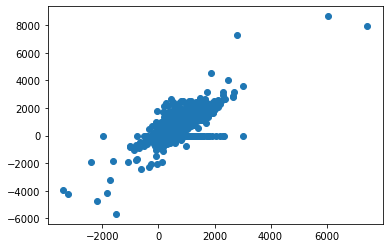

In [361]:
plt.scatter(new_df_train['pred_revenue'], new_df_train['revenue'])
plt.show()

In [362]:
np.mean((new_df_train['revenue'] - new_df_train['pred_revenue']).to_numpy() ** 2)

23414.276072862613

In [363]:
new_df_train = add_arrival_date(new_df_train)

In [364]:
new_df_train_sum = new_df_train.groupby('arrival_date').sum()

In [365]:
new_df_train_sum.head()

,ID,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,revenue,pred_adr,pred_is_canceled,pred_revenue
arrival_date,,,,,,,,,,,,,,,,,,,,,
2015-07-01,7381,19,22783,245830,3294,122,45,335,223,2.0,...,9,33,0,8490.218248,4,39,20311.186621,8663.113281,45.041138,17390.947003
2015-07-02,15624,57,14241,187395,2511,186,75,291,186,4.0,...,3,4,0,5938.812547,5,38,16530.645277,5829.162598,53.539928,15652.553765
2015-07-03,13580,19,4080,112840,1512,168,53,187,112,4.0,...,0,6,0,4709.476079,7,27,12966.714164,4594.839355,17.732218,13083.151164
2015-07-04,27676,43,13637,177320,2376,352,164,275,171,8.0,...,0,8,0,6301.681498,7,45,17480.654256,6584.820801,50.991840,14599.255998
2015-07-05,20405,16,4433,106795,1484,265,121,195,103,10.0,...,0,11,0,4807.284096,13,24,19591.458478,5317.511230,17.063648,19411.313094


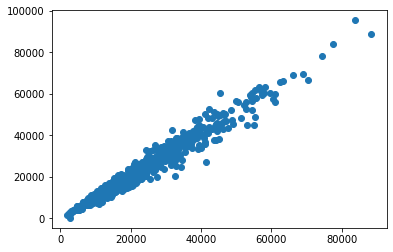

In [366]:
plt.scatter(new_df_train_sum['pred_revenue'], new_df_train_sum['revenue'])
plt.show()

In [367]:
np.mean((new_df_train_sum['revenue'] - new_df_train_sum['pred_revenue']).to_numpy() ** 2)

9039345.215140134

In [368]:
y_train = pd.read_csv(Config.train_label_path)
train = new_df_train_sum.merge(y_train, left_index=True, right_on='arrival_date')

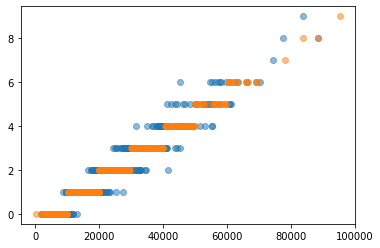

In [369]:
plt.scatter(train['pred_revenue'], train['label'], alpha=.5)
plt.scatter(train['revenue'], train['label'], alpha=.5)
plt.show()

In [375]:
train[sorted(list(set(train.columns) - {'adr', 'reservation_status', 'reservation_status_date', 'is_canceled', 'ID', 'index'}))]

,adults,arrival_date,arrival_date_day_of_month,arrival_date_week_number,arrival_date_year,babies,booking_changes,children,days_in_waiting_list,is_repeated_guest,...,pred_adr,pred_is_canceled,pred_revenue,previous_bookings_not_canceled,previous_cancellations,required_car_parking_spaces,revenue,stays_in_week_nights,stays_in_weekend_nights,total_of_special_requests
0,223,2015-07-01,122,3294,245830,0,33,2.0,0,1,...,8663.113281,45.041138,17390.947003,9,11,4,20311.186621,335,45,39
1,186,2015-07-02,186,2511,187395,0,4,4.0,0,22,...,5829.162598,53.539928,15652.553765,3,47,5,16530.645277,291,75,38
2,112,2015-07-03,168,1512,112840,0,6,4.0,0,0,...,4594.839355,17.732218,13083.151164,0,1,7,12966.714164,187,53,27
3,171,2015-07-04,352,2376,177320,2,8,8.0,0,0,...,6584.820801,50.991840,14599.255998,0,32,7,17480.654256,275,164,45
4,103,2015-07-05,265,1484,106795,0,11,10.0,0,1,...,5317.511230,17.063648,19411.313094,0,8,13,19591.458478,195,121,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,338,2017-03-27,4941,2379,369111,0,31,2.0,0,9,...,14174.454102,74.646469,24973.713279,18,1,8,26217.381380,326,192,115
636,155,2017-03-28,2464,1144,177496,1,11,3.0,0,7,...,5760.766113,27.851446,13125.492186,43,1,4,16185.177703,308,46,53
637,258,2017-03-29,4466,2002,310618,2,31,8.0,0,17,...,10985.431641,38.785316,21611.717767,72,2,13,24002.255525,399,38,95
638,311,2017-03-30,5370,2327,361043,3,48,9.0,0,6,...,12141.252930,64.793983,27888.762828,39,1,9,33095.297394,510,97,108


In [432]:
sec_x_train = train[sorted(list(set(train.columns) - {'revenue', 'label', 'arrival_date', 'adr', 'reservation_status', 'reservation_status_date', 'is_canceled', 'ID', 'index'}))].to_numpy()
sec_y_train = train['label'].to_numpy()

In [433]:
print(sec_x_train.shape, sec_y_train.shape)

(640, 19) (640,)


In [578]:
sec_regr = XGBRegressor(
    n_estimators=100,
    learning_rate=1,
    max_depth=2,
    subsample=.6,
    n_jobs=6,
    colsample_bytree=.7,
    random_state=1126,
    gamma=20
)
sec_regr.fit(sec_x_train, sec_y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=20, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=1, max_delta_step=0, max_depth=2, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=6,
             num_parallel_tree=1, random_state=1126, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=0.6, tree_method='exact',
             validate_parameters=1, verbosity=None)

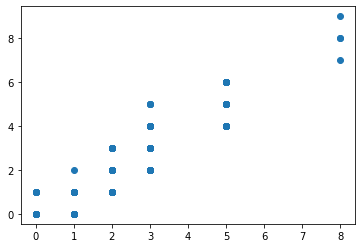

In [579]:
plt.scatter(np.round(sec_regr.predict(sec_x_train)), sec_y_train)

In [580]:
np.mean((np.round(sec_regr.predict(sec_x_train)) - sec_y_train)**2)

0.26875

In [581]:
np.mean((sec_regr.predict(sec_x_train) - sec_y_train)**2)

0.28922157801585613

In [304]:
df_test = pd.read_csv(Config.test_path)
df_test.head()

,ID,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
0,91531,City Hotel,75,2017,April,13,1,2,5,2,...,D,D,0,No Deposit,9.0,NaN,0,Transient,0,1
1,91532,City Hotel,208,2017,April,13,1,4,10,2,...,A,A,0,No Deposit,9.0,NaN,0,Transient,0,1
2,91533,Resort Hotel,12,2017,April,13,1,2,5,2,...,A,A,0,No Deposit,40.0,NaN,0,Contract,0,1
3,91534,City Hotel,76,2017,April,13,1,2,5,3,...,D,D,0,No Deposit,9.0,NaN,0,Transient,0,0
4,91535,City Hotel,9,2017,April,13,1,2,4,2,...,F,F,0,No Deposit,9.0,NaN,0,Transient,0,0


In [305]:
df_test.shape

(27859, 29)

In [306]:
categories = df_test[sorted(list(set(nominal+ordinal) - {'adr', 'reservation_status', 'reservation_status_date', 'is_canceled', 'ID', 'index'}))].astype(str).to_numpy()
cat = enc.transform(categories)

In [307]:
cat.shape

(27859, 941)

In [308]:
num = df_test[sorted(list(set(df_test.columns) - set(nominal+ordinal) - {'adr', 'reservation_status', 'reservation_status_date', 'is_canceled', 'ID', 'index'}))].to_numpy()

In [309]:
num.shape

(27859, 13)

In [310]:
tmp = np.concatenate((cat, num), axis=1)
x_test = tmp.copy()

In [311]:
print('test:', x_test.shape)

test: (27859, 954)


In [312]:
pred_adr = regr.predict(x_test)
prob_res = clf.predict_proba(x_test)

In [313]:
pred_res = 1- prob_res[:,0].copy()

In [314]:
pred_res

array([0.3304512 , 0.45915854, 0.3264494 , ..., 0.2630936 , 0.0774318 ,
       0.11267251], dtype=float32)

In [315]:
tmp = clf.predict(x_test)

In [340]:
new_df_test = df_test.copy().reset_index()
new_df_test['pred_adr'] = pred_adr
# new_df_test['pred_is_canceled'] = (tmp != 0).astype(float)
new_df_test['pred_is_canceled'] = pred_res
new_df_test['pred_revenue'] = new_df_test['pred_adr'] * np.sum(new_df_test[['stays_in_weekend_nights', 'stays_in_week_nights']], axis=1) * (1-new_df_test['pred_is_canceled'])
new_df_test[['pred_adr', 'pred_is_canceled', 'pred_revenue']].head()

,pred_adr,pred_is_canceled,pred_revenue
0,106.176231,0.330451,497.631185
1,50.756371,0.459159,384.316094
2,72.290970,0.326449,340.841386
3,127.737000,0.736109,235.960549
4,192.197525,0.655807,396.917685


In [342]:
new_df_test[['pred_adr', 'pred_is_canceled', 'pred_revenue']].describe()

,pred_adr,pred_is_canceled,pred_revenue
count,27859.000000,27859.000000,27859.000000
mean,100.431442,0.388902,218.055493
std,44.444550,0.296699,219.610459
min,-52.252293,0.035430,-736.467024
25%,73.499130,0.127105,80.061305
50%,96.364334,0.326151,161.462610
75%,123.372730,0.652852,287.201120
max,336.267792,0.979969,3381.900593


In [318]:
new_df_test = add_arrival_date(new_df_test)

In [319]:
new_df_test_sum = new_df_test.groupby('arrival_date').sum()

In [320]:
new_df_test_sum.head()

,index,ID,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,pred_adr,pred_is_canceled,pred_revenue
arrival_date,,,,,,,,,,,,,,,,,,,,,
2017-04-01,8646,12090738,12575,266244,1716,132,225,299,273,20.0,...,7,25,15944.0,163.0,205,7,79,12571.656250,43.669472,30392.908932
2017-04-02,17232,8804208,7043,193632,1344,192,186,181,187,8.0,...,10,29,5736.0,301.0,63,5,112,9347.386719,29.957003,23326.407192
2017-04-03,79233,21222894,17786,465927,3234,693,251,513,407,19.0,...,19,51,10799.0,5482.0,211,9,120,19404.341797,92.718262,37271.302628
2017-04-04,65125,11506500,13068,252125,1750,500,26,355,239,19.0,...,31,39,7435.0,14441.0,32,7,63,10155.100586,66.475464,16610.248061
2017-04-05,178794,23244606,30182,508284,3528,1260,54,824,429,13.0,...,40,186,13759.0,25140.0,345,17,73,14248.525391,88.749786,29499.712056


In [338]:
new_df_test_sum['pred_revenue'].describe()

count      153.000000
mean     39704.627375
std      13162.305160
min      14958.994418
25%      30342.657231
50%      37271.302628
75%      46161.786468
max      86188.207975
Name: pred_revenue, dtype: float64

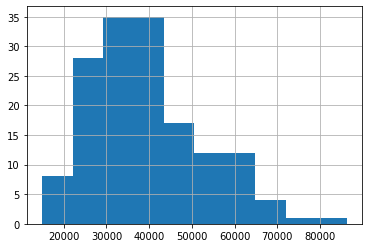

In [337]:
new_df_test_sum['pred_revenue'].hist()
plt.show()

In [328]:
test_index = new_df_test_sum.index

In [515]:
sorted(list(set(train.columns) - {'revenue', 'label', 'arrival_date', 'adr', 'reservation_status', 'reservation_status_date', 'is_canceled', 'ID', 'index'}))

['adults',
 'arrival_date_day_of_month',
 'arrival_date_week_number',
 'arrival_date_year',
 'babies',
 'booking_changes',
 'children',
 'days_in_waiting_list',
 'is_repeated_guest',
 'lead_time',
 'pred_adr',
 'pred_is_canceled',
 'pred_revenue',
 'previous_bookings_not_canceled',
 'previous_cancellations',
 'required_car_parking_spaces',
 'stays_in_week_nights',
 'stays_in_weekend_nights',
 'total_of_special_requests']

In [517]:
sorted(list(set(new_df_test_sum.columns) - {'company', 'agent', 'label', 'arrival_date', 'adr', 'reservation_status', 'reservation_status_date', 'is_canceled', 'ID', 'index'}))

['adults',
 'arrival_date_day_of_month',
 'arrival_date_week_number',
 'arrival_date_year',
 'babies',
 'booking_changes',
 'children',
 'days_in_waiting_list',
 'is_repeated_guest',
 'lead_time',
 'pred_adr',
 'pred_is_canceled',
 'pred_revenue',
 'previous_bookings_not_canceled',
 'previous_cancellations',
 'required_car_parking_spaces',
 'stays_in_week_nights',
 'stays_in_weekend_nights',
 'total_of_special_requests']

In [518]:
sec_x_test = new_df_test_sum[sorted(list(set(new_df_test_sum.columns) - {'company', 'agent', 'label', 'arrival_date', 'adr', 'reservation_status', 'reservation_status_date', 'is_canceled', 'ID', 'index'}))].to_numpy()

In [519]:
print(sec_x_test.shape)

(153, 19)


In [520]:
pd.DataFrame(sec_x_train).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000,640.000000
mean,262.528125,2261.603125,4030.520312,288292.581250,1.196875,30.529688,13.009375,423.642187,4.846875,13770.600000,12096.985358,54.043121,24720.561895,19.245313,15.765625,9.370313,350.153125,128.609375,75.554688
std,122.583391,1701.546132,3007.869121,129907.954697,1.435735,21.279989,11.309001,1438.136584,5.678804,12258.842105,6490.372941,37.267514,13695.571776,26.662044,56.877719,4.608836,167.849143,102.369413,35.627750
min,28.000000,44.000000,44.000000,38285.000000,0.000000,1.000000,0.000000,0.000000,0.000000,206.000000,1085.484009,3.250279,1890.326178,0.000000,0.000000,0.000000,18.000000,2.000000,12.000000
25%,173.750000,862.000000,1665.750000,193632.000000,0.000000,16.000000,4.000000,0.000000,1.000000,4579.750000,7232.818726,27.670035,14777.544569,1.750000,0.000000,6.000000,225.000000,46.000000,49.750000
50%,251.500000,1943.000000,3527.500000,270144.000000,1.000000,27.000000,10.000000,0.000000,3.000000,11253.500000,11373.921387,45.975220,22672.545267,9.000000,2.000000,9.000000,330.500000,99.000000,72.000000
75%,338.250000,3223.500000,5665.500000,371539.750000,2.000000,39.000000,18.000000,21.250000,7.000000,18585.750000,16032.293701,72.534515,32636.535128,27.000000,10.000000,12.000000,455.000000,189.250000,98.000000
max,871.000000,9352.000000,21952.000000,902720.000000,10.000000,215.000000,74.000000,13380.000000,77.000000,75383.000000,38150.414062,241.251450,88455.069768,220.000000,699.000000,32.000000,1014.000000,802.000000,252.000000


In [521]:
pd.DataFrame(sec_x_test).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.000000,153.00000,153.000000,153.000000,153.000000,153.000000
mean,350.372549,2867.156863,4337.091503,367265.379085,1.196078,44.836601,26.647059,39.156863,4.627451,23560.078431,18287.055977,70.813120,39704.627375,26.477124,2.03268,9.588235,486.294118,185.836601,129.771242
std,86.465530,1826.925171,1266.510630,94392.681665,1.214273,21.651990,14.356582,76.729713,3.486595,9796.895902,4813.604189,32.977541,13162.305160,30.622293,2.91642,3.997581,129.886939,119.415708,34.943280
min,174.000000,132.000000,1344.000000,179513.000000,0.000000,12.000000,2.000000,0.000000,0.000000,7043.000000,7518.973633,26.717773,14958.994418,0.000000,0.00000,2.000000,181.000000,4.000000,54.000000
25%,285.000000,1408.000000,3375.000000,298516.000000,0.000000,32.000000,15.000000,0.000000,2.000000,17381.000000,14870.727539,48.994129,30342.657231,5.000000,0.00000,7.000000,393.000000,80.000000,108.000000
50%,343.000000,2672.000000,4350.000000,350958.000000,1.000000,41.000000,24.000000,0.000000,4.000000,21414.000000,17885.642578,63.903679,37271.302628,15.000000,1.00000,9.000000,479.000000,165.000000,129.000000
75%,395.000000,4020.000000,5208.000000,413485.000000,2.000000,51.000000,36.000000,52.000000,6.000000,28322.000000,21485.457031,79.364105,46161.786468,38.000000,3.00000,12.000000,570.000000,275.000000,147.000000
max,653.000000,9570.000000,7751.000000,679729.000000,6.000000,186.000000,68.000000,549.000000,15.000000,68361.000000,32902.046875,218.820038,86188.207975,128.000000,16.00000,25.000000,968.000000,549.000000,253.000000


In [584]:
label = np.round(sec_regr.predict(sec_x_test))

In [585]:
label

array([3., 2., 3., 1., 3., 2., 2., 3., 3., 3., 2., 2., 3., 3., 3., 3., 3.,
       2., 2., 2., 3., 3., 3., 3., 1., 2., 2., 5., 5., 3., 3., 3., 2., 3.,
       3., 3., 3., 3., 3., 2., 3., 3., 3., 3., 3., 2., 2., 3., 3., 3., 3.,
       3., 2., 3., 3., 2., 2., 3., 3., 2., 2., 3., 3., 3., 3., 5., 2., 2.,
       3., 3., 3., 5., 3., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 2., 3., 3., 5., 3., 5., 5., 2., 3., 3., 3., 5., 5., 3.,
       3., 3., 3., 5., 5., 5., 3., 2., 3., 3., 5., 5., 5., 3., 3., 3., 3.,
       5., 5., 5., 5., 5., 5., 5., 5., 5., 8., 3., 3., 5., 3., 5., 5., 5.,
       5., 5., 5., 5., 5., 5., 5., 3., 5., 5., 5., 5., 5., 8., 3., 3., 3.],
      dtype=float32)

In [586]:
from HTML.save import save_prediction
save_prediction('../outputs//xgboost3.csv', test_index, label)